**1️⃣ Load Data**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail (4).xlsx


In [2]:
import pandas as pd
df = pd.read_excel('Online Retail (1).xlsx')

**2️⃣ Explore the Data**

In [3]:
# Data Overview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Check Data for Null Values and Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Shape of Data
df.shape

(541909, 8)

In [6]:
# Check Number of Null Values in the DataFrame
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [7]:
# Check DataFrame for Duplicates
df.duplicated().sum()

np.int64(5268)

**3️⃣ Clean the Data**

In [8]:
df.dropna(subset=['CustomerID'], inplace=True)

In [9]:
df.drop_duplicates(inplace=True)

**4️⃣ RFM Analysis**

In [10]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

In [11]:
# Remove negative/zero Amounts (mostly returns)
df = df[df['Amount'] > 0]

In [12]:
# Define the last day
evaluation_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [13]:
# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (evaluation_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Amount': 'sum'                                           # Monetary
}).reset_index()

In [14]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [15]:
# Calculate R, F, M Scores from 1 to 5
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [16]:
# Combine them into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [17]:
# Segment the customers
def segment_customer(score):
    if score == '555':
        return 'Best Customer'
    elif score[0] == '5':
        return 'Recent Customer'
    elif score[1] == '5':
        return 'Frequent Buyer'
    elif score[2] == '5':
        return 'Big Spender'
    else:
        return 'Others'

In [18]:
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

In [19]:
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Big Spender
1,12347.0,2,7,4310.00,5,5,5,555,Best Customer
2,12348.0,75,4,1797.24,2,4,4,244,Others
3,12349.0,19,1,1757.55,4,1,4,414,Others
4,12350.0,310,1,334.40,1,1,2,112,Others
5,12352.0,36,8,2506.04,3,5,5,355,Frequent Buyer
6,12353.0,204,1,89.00,1,1,1,111,Others
7,12354.0,232,1,1079.40,1,1,4,114,Others
8,12355.0,214,1,459.40,1,1,2,112,Others
9,12356.0,23,3,2811.43,4,3,5,435,Big Spender


In [20]:
rfm.Segment.value_counts().reset_index()

,Segment,count
0,Others,2859
1,Recent Customer,521
2,Frequent Buyer,429
3,Best Customer,347
4,Big Spender,182


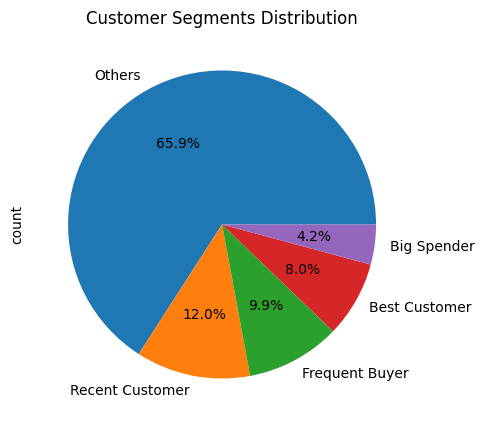

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Customer Segments Distribution
rfm['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5, 5), title='Customer Segments Distribution')
plt.show()

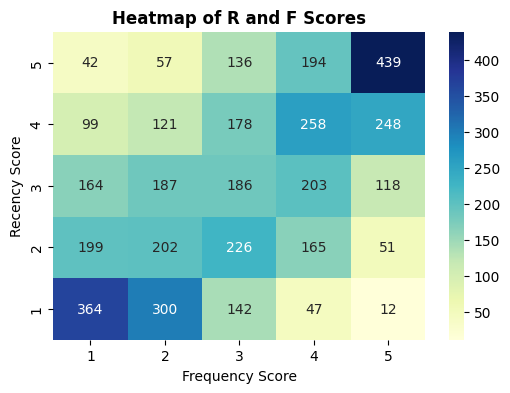

In [22]:
# Recency vs Frequency Scores
rfm_heatmap = rfm.groupby(['R_Score', 'F_Score']).size().unstack()
plt.figure(figsize=(6, 4))
sns.heatmap(rfm_heatmap, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Heatmap of R and F Scores', weight='bold')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

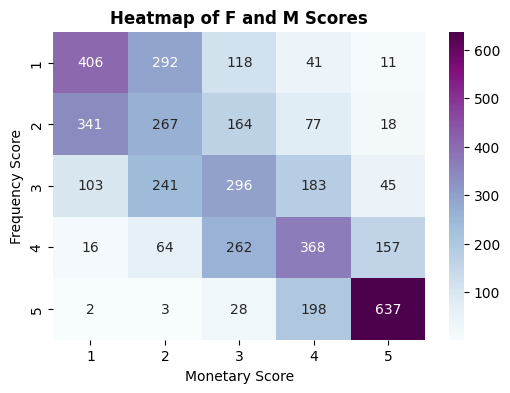

In [23]:
rfm_monetary_heatmap = rfm.groupby(['F_Score', 'M_Score']).size().unstack(fill_value=0)

# Frequency vs Monetary Scores
plt.figure(figsize=(6, 4))
sns.heatmap(rfm_monetary_heatmap, cmap='BuPu', annot=True, fmt='d')
plt.title('Heatmap of F and M Scores', weight='bold')
plt.xlabel('Monetary Score')
plt.ylabel('Frequency Score')
plt.show()

**5️⃣ General Analysis**

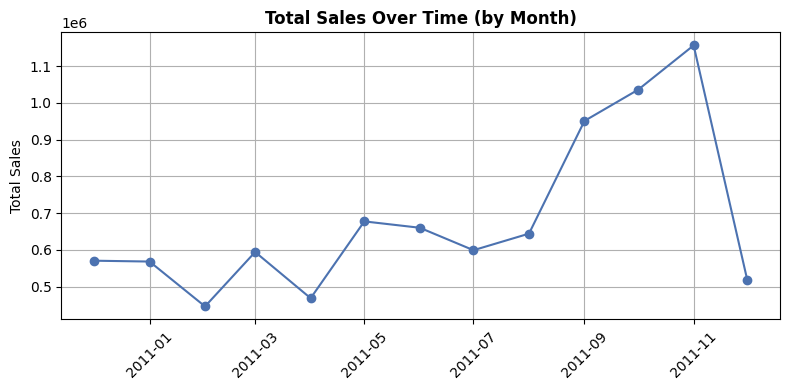

In [24]:
# Total Sales Over Time (by Month)
df['Sales'] = df['Quantity'] * df['UnitPrice']
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
monthly_sales = df.groupby('InvoiceMonth')['Sales'].sum().reset_index()

plt.figure(figsize=(8, 4))
plt.plot(monthly_sales['InvoiceMonth'], monthly_sales['Sales'], marker='o', color='#4C72B0')
plt.title('Total Sales Over Time (by Month)', weight='bold')
plt.xlabel('')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

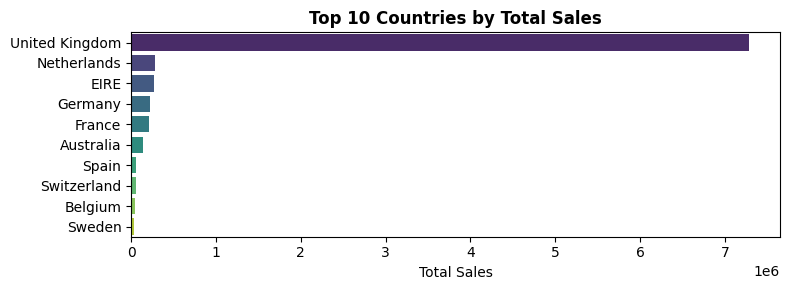

In [25]:
# Top 10 Countries by Total Sales
sales_by_country = df.groupby('Country')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 3))
top_countries = sales_by_country.head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')

plt.title('Top 10 Countries by Total Sales', weight='bold')
plt.xlabel('Total Sales')
plt.ylabel('')
plt.tight_layout()
plt.show()